**Step 1: Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings("ignore")

**Step 2: Load Dataset and Preprocessing**

In [2]:
df = pd.read_csv("/kaggle/input/car-evaluation-data-set/car_evaluation.csv")
df.head()

,vhigh,vhigh.1,2,2.1,small,low,unacc
0,vhigh,vhigh,2,2,small,med,unacc
1,vhigh,vhigh,2,2,small,high,unacc
2,vhigh,vhigh,2,2,med,low,unacc
3,vhigh,vhigh,2,2,med,med,unacc
4,vhigh,vhigh,2,2,med,high,unacc


In [3]:
df.columns = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,med,unacc
1,vhigh,vhigh,2,2,small,high,unacc
2,vhigh,vhigh,2,2,med,low,unacc
3,vhigh,vhigh,2,2,med,med,unacc
4,vhigh,vhigh,2,2,med,high,unacc


In [4]:
df.isnull().sum()

buying      0
maint       0
doors       0
persons     0
lug_boot    0
safety      0
class       0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1727 entries, 0 to 1726
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1727 non-null   object
 1   maint     1727 non-null   object
 2   doors     1727 non-null   object
 3   persons   1727 non-null   object
 4   lug_boot  1727 non-null   object
 5   safety    1727 non-null   object
 6   class     1727 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


In [6]:
X = df.drop('class', axis=1)
y = df['class']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), X.columns.tolist())
])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

**Step 3: Exploratory Data Analysis (EDA)**

**Class Distribution**

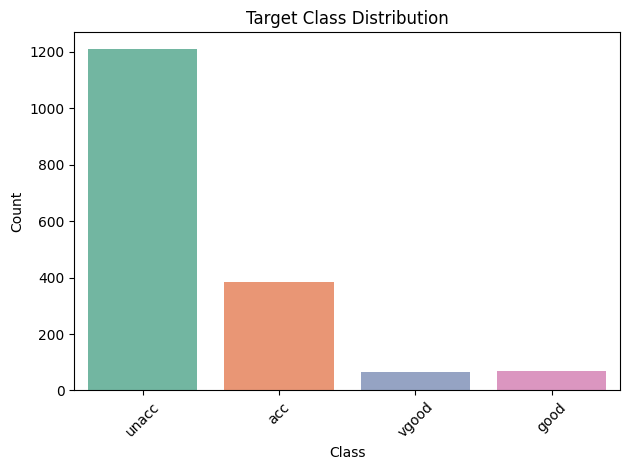

In [8]:
sns.countplot(x='class', data=df, palette='Set2')
plt.title("Target Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Feature Distribution per Target Class**

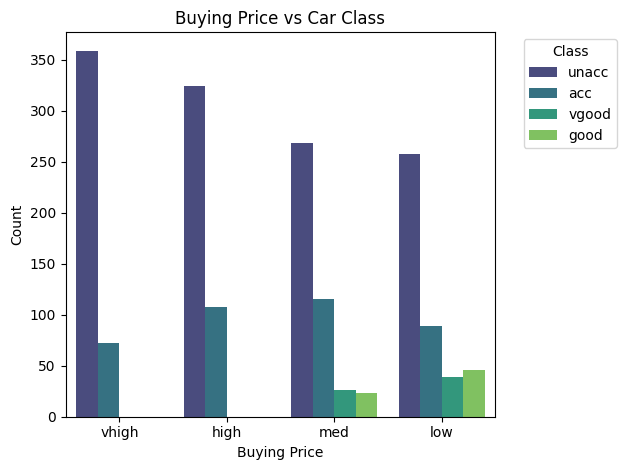

In [9]:
# Buying Price vs Class
sns.countplot(x='buying', hue='class', data=df, palette='viridis')
plt.title("Buying Price vs Car Class")
plt.xlabel("Buying Price")
plt.ylabel("Count")
plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

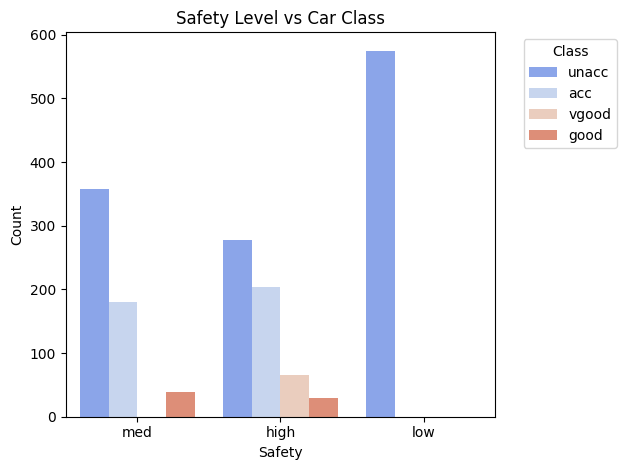

In [10]:
# Safety Level vs Class
sns.countplot(x='safety', hue='class', data=df, palette='coolwarm')
plt.title("Safety Level vs Car Class")
plt.xlabel("Safety")
plt.ylabel("Count")
plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Heatmap of Encoded Features**

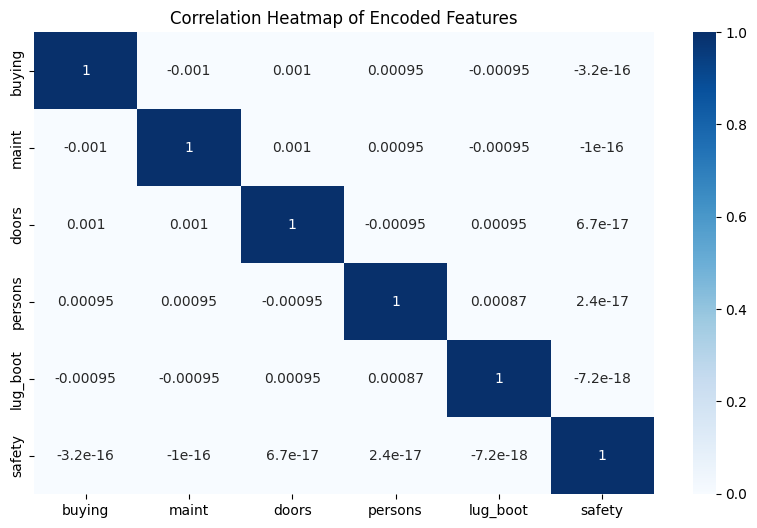

In [11]:
X_encoded = X.copy()
encoder = OrdinalEncoder()
X_encoded[X.columns] = encoder.fit_transform(X)

plt.figure(figsize=(10, 6))
sns.heatmap(X_encoded.corr(), annot=True, cmap='Blues')
plt.title("Correlation Heatmap of Encoded Features")
plt.show()

**Step 4: Define Models**

In [12]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=200),
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(),
    "GradientBoosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "SVC": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "NaiveBayes": GaussianNB()
}

**Train and Evaluation without Tuning**

In [13]:
results_untuned = {}

for name, model in models.items():
    if name == "NaiveBayes":
        dense_preprocessor = ColumnTransformer(
            transformers=[('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), X.columns.tolist())]
        )
        pipe = make_pipeline(dense_preprocessor, model)
    else:
        pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test) if hasattr(pipe, "predict_proba") else None

    results_untuned[name] = {
        "model": models,
        "accuracy": accuracy_score(y_test, y_pred),
        "conf_matrix": confusion_matrix(y_test, y_pred),
        "report": classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True),
        "y_pred": y_pred,
        "y_proba": y_proba,
        "pipeline": pipe
    }

print("Untuned Model Accuracies:\n")
for name, result in results_untuned.items():
    print(f"{name:20s} : {result['accuracy']:.4f}")

Untuned Model Accuracies:

LogisticRegression   : 0.9075
DecisionTree         : 0.9740
RandomForest         : 0.9798
GradientBoosting     : 0.9884
AdaBoost             : 0.8035
SVC                  : 0.9827
KNN                  : 0.9162
NaiveBayes           : 0.8121


In [14]:
best_untuned = max(results_untuned.items(), key=lambda x: x[1]['accuracy'])
best_untuned_name = best_untuned[0]
best_untuned_result = best_untuned[1]

print(f"Best Untuned Model: {best_untuned_name}")
print("Accuracy:", best_untuned_result['accuracy'])

Best Untuned Model: GradientBoosting
Accuracy: 0.9884393063583815


**Confusion Matrix and Classification Report for best untuned model**

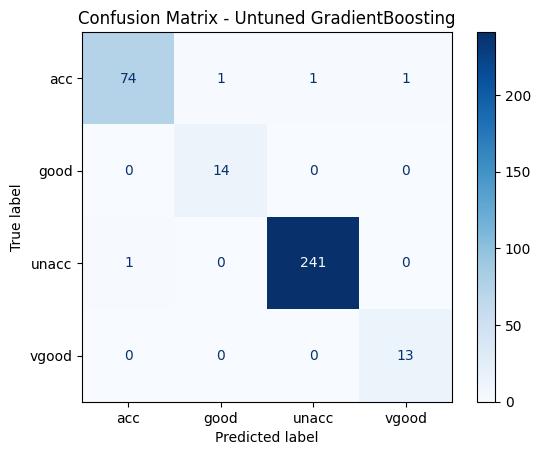


Classification Report for Untuned GradientBoosting
              precision    recall  f1-score   support

         acc       0.99      0.96      0.97        77
        good       0.93      1.00      0.97        14
       unacc       1.00      1.00      1.00       242
       vgood       0.93      1.00      0.96        13

    accuracy                           0.99       346
   macro avg       0.96      0.99      0.97       346
weighted avg       0.99      0.99      0.99       346



In [15]:
disp = ConfusionMatrixDisplay(
    confusion_matrix=results_untuned[best_untuned_name]['conf_matrix'], display_labels=label_encoder.classes_ 
)
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix - Untuned {best_untuned_name}")
plt.show()
print(f"\nClassification Report for Untuned {best_untuned_name}")
print(classification_report(y_test, results_untuned[best_untuned_name]["y_pred"], target_names=label_encoder.classes_))

**Step 5: Define Param Grids**

In [16]:
param_grids = {
    "LogisticRegression": {'classifier__C': [0.1, 1, 10]},
    "DecisionTree": {'classifier__max_depth': [None, 5, 10], 'classifier__min_samples_split': [2, 5]},
    "RandomForest": {'classifier__n_estimators': [50, 100], 'classifier__max_depth': [None, 10]},
    "GradientBoosting": {'classifier__n_estimators': [50, 100], 'classifier__learning_rate': [0.05, 0.1]},
    "AdaBoost": {'classifier__n_estimators': [50, 100]},
    "SVC": {'classifier__C': [0.1, 1, 10], 'classifier__kernel': ['rbf', 'linear']},
    "KNN": {'classifier__n_neighbors': [3, 5, 7]}
}

**Train and Evaluation with Tuning**

In [17]:
results_tuned = {}

for name, model in models.items():
    if name not in param_grids:
        continue
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    grid = GridSearchCV(pipe, param_grids[name], cv=3, n_jobs=-1)
    grid.fit(X_train, y_train)
    
    y_pred = grid.predict(X_test)
    y_proba = grid.predict_proba(X_test) if hasattr(grid, "predict_proba") else None
    
    results_tuned[name] = {
        "accuracy": accuracy_score(y_test, y_pred),
        "conf_matrix": confusion_matrix(y_test, y_pred),
        "report": classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True),
        "y_pred": y_pred,
        "y_proba": y_proba,
        "best_estimator": grid.best_estimator_
    }

In [18]:
print("Tuned Model Accuracies:\n")
for name, result in results_tuned.items():
    print(f"{name:20s} : {result['accuracy']:.4f}")

Tuned Model Accuracies:

LogisticRegression   : 0.9277
DecisionTree         : 0.9769
RandomForest         : 0.9740
GradientBoosting     : 0.9884
AdaBoost             : 0.8035
SVC                  : 1.0000
KNN                  : 0.9249


In [19]:
best_tuned = max(results_tuned.items(), key=lambda x: x[1]['accuracy'])
best_tuned_name = best_tuned[0]
best_tuned_result = best_tuned[1]

print(f"Best Untuned Model: {best_tuned_name}")
print("Accuracy:", best_tuned_result['accuracy'])

Best Untuned Model: SVC
Accuracy: 1.0


**Confusion Matrix and Classification Report for best tuned model**

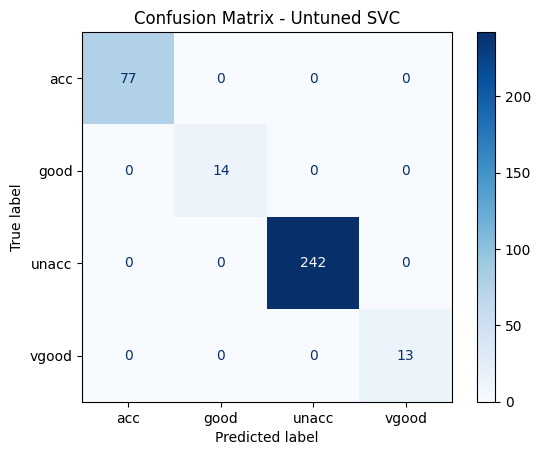


Classification Report for Untuned SVC
              precision    recall  f1-score   support

         acc       1.00      1.00      1.00        77
        good       1.00      1.00      1.00        14
       unacc       1.00      1.00      1.00       242
       vgood       1.00      1.00      1.00        13

    accuracy                           1.00       346
   macro avg       1.00      1.00      1.00       346
weighted avg       1.00      1.00      1.00       346



In [20]:
disp = ConfusionMatrixDisplay(
    confusion_matrix=results_tuned[best_tuned_name]['conf_matrix'], display_labels=label_encoder.classes_ 
)
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix - Untuned {best_tuned_name}")
plt.show()
print(f"\nClassification Report for Untuned {best_tuned_name}")
print(classification_report(y_test, results_tuned[best_tuned_name]["y_pred"], target_names=label_encoder.classes_))

**Step 6: Accuracy Comparison**

In [21]:
comparison_df = pd.DataFrame({
    "Model": list(models.keys()),
    "Accuracy (Untuned)": [results_untuned[m]["accuracy"] for m in models],
    "Accuracy (Tuned)": [results_tuned[m]["accuracy"] if m in results_tuned else None for m in models]
})
print(comparison_df.sort_values("Accuracy (Tuned)", ascending=False))

                Model  Accuracy (Untuned)  Accuracy (Tuned)
5                 SVC            0.982659          1.000000
3    GradientBoosting            0.988439          0.988439
1        DecisionTree            0.973988          0.976879
2        RandomForest            0.979769          0.973988
0  LogisticRegression            0.907514          0.927746
6                 KNN            0.916185          0.924855
4            AdaBoost            0.803468          0.803468
7          NaiveBayes            0.812139               NaN


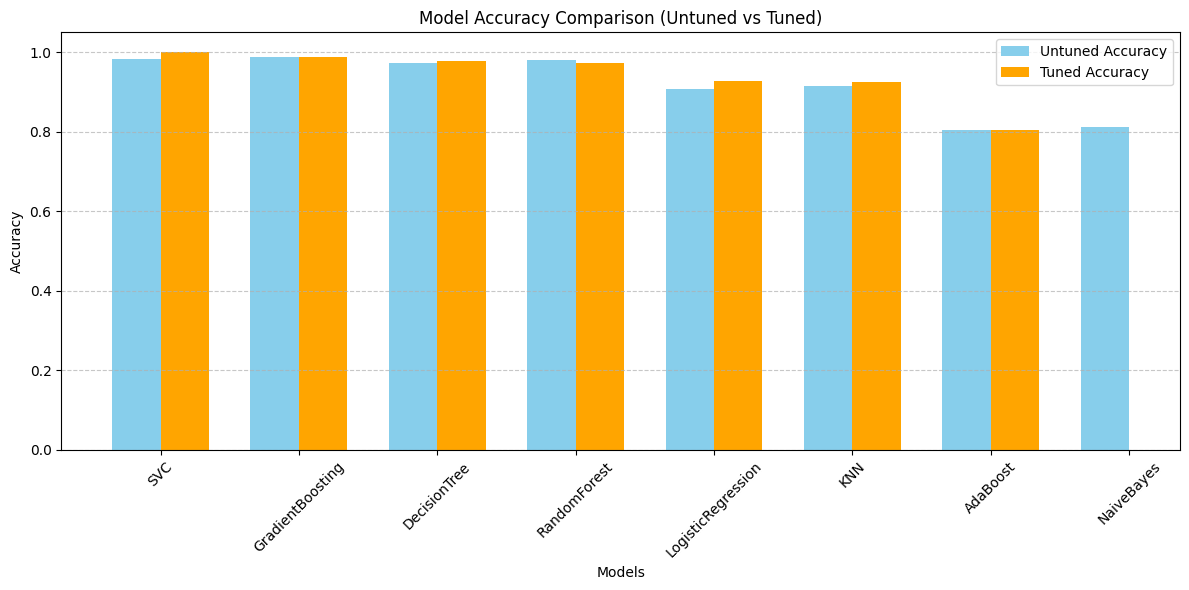

In [22]:
comparison_df_sorted = comparison_df.sort_values("Accuracy (Tuned)", ascending=False)

plt.figure(figsize=(12, 6))
bar_width = 0.35
x = range(len(comparison_df_sorted))

plt.bar(x, comparison_df_sorted["Accuracy (Untuned)"], width=bar_width, label='Untuned Accuracy', color='skyblue')
plt.bar([i + bar_width for i in x], comparison_df_sorted["Accuracy (Tuned)"], width=bar_width, label='Tuned Accuracy', color='orange')

plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison (Untuned vs Tuned)")
plt.xticks([i + bar_width / 2 for i in x], comparison_df_sorted["Model"], rotation=45)
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**Step 7: Prediction**

In [23]:
best_tuned = max(results_tuned.items(), key=lambda x: x[1]['accuracy'])
best_tuned_name = best_tuned[0]
best_tuned_result = best_tuned[1]

final_df = pd.DataFrame({
    "Actual": label_encoder.inverse_transform(y_test),
    "Untuned_Pred": label_encoder.inverse_transform(best_untuned_result["y_pred"]),
    "Tuned_Pred": label_encoder.inverse_transform(best_tuned_result["y_pred"])
})

final_df.head(10)

,Actual,Untuned_Pred,Tuned_Pred
0,good,good,good
1,unacc,unacc,unacc
2,unacc,unacc,unacc
3,unacc,unacc,unacc
4,acc,acc,acc
5,unacc,unacc,unacc
6,unacc,unacc,unacc
7,acc,acc,acc
8,unacc,unacc,unacc
9,unacc,unacc,unacc
